### Import Libraries

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
import numpy as np
import quantecon as qe
from _model_individual_xxx import FireProblem

### Plotting Preferences

In [3]:
from matplotlib import cm
%matplotlib inline

### Solve for the Value Function

In [ ]:
fp = FireProblem(w=40,y_0=-1,sig2_0=1,sig2_star=2,sp=3,st=0.1)
v_init = np.array([np.ones((fp.n, 1, fp.t.size))*(i-fp.y.size/2) for i in range(fp.y.size)]).reshape(fp.n,fp.y.size,fp.t.size)
#initial guess has value increasing in match beliefs
v_init = np.c_[np.array([np.ones((fp.n, 1))*(-i+fp.y.size/2) for i in range(fp.y.size)]).reshape(fp.n,fp.y.size,1), v_init]
#for tenure zero the guess is decreasing in match beliefs
v = qe.compute_fixed_point(fp.bellman_operator, v_init, error_tol=1e-3, print_skip=10, max_iter=1000)
#includes time zero when no decision is made according to the model
#includes duplicate value column at T_max

Iteration    Distance       Elapsed (seconds)
---------------------------------------------


### Solve for the Optimal Policy

In [4]:
optimal_policy = fp.get_greedy(v)
#includes time zero when no decision is made according to the model

### Plot the Value Function

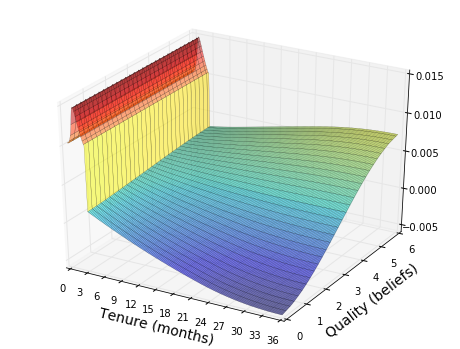

In [5]:
v1 = v[:,:,1:] #remove zero
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
tg, yg = np.meshgrid(fp.t, fp.y)
ax.plot_surface(tg,
                yg,
                v1[0,:,:], #for worker 0
                rstride=2, cstride=2,
                cmap=cm.jet,
                alpha=0.5,
                linewidth=0.25)

ax.set_zlim(np.amin(v1[0,:,:]), np.amax(v1[0,:,:]))
ax.set_xlabel('Tenure (months)', fontsize=14)
ax.set_ylabel('Quality (beliefs)', fontsize=14)

ax.set_xlim(0,fp.T_max)
labels = [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36]
plt.xticks(np.linspace(0, fp.T_max+1, (fp.T_max+1)/30+1), labels)
plt.show()

### Plot the Optimal Policy

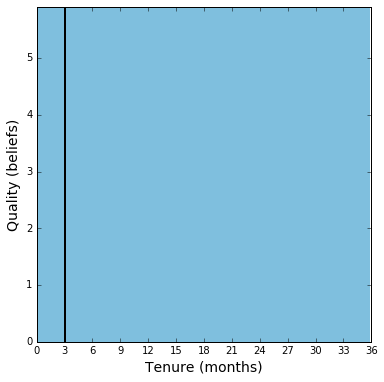

In [6]:
optimal_policy1 = optimal_policy[:,:,1:] #remove zero
fig, ax = plt.subplots(figsize=(6,6))
tg, yg = np.meshgrid(fp.t, fp.y)

lvls=(-0.5, 0.5)
ax.contourf(tg, yg, optimal_policy1[0,:,:], levels=lvls, cmap=cm.winter, alpha=0.5) #for worker 0
ax.contour(tg, yg, optimal_policy1[0,:,:], colors='k', levels=lvls, linewidths=1) #for worker 0

ax.set_xlabel('Tenure (months)', fontsize=14)
ax.set_ylabel('Quality (beliefs)', fontsize=14)

ax.set_xlim(0,fp.T_max)
labels = [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36]
plt.xticks(np.linspace(0, fp.T_max+1, (fp.T_max+1)/30+1), labels)
plt.show()

In [7]:
%matplotlib

Using matplotlib backend: Qt4Agg


In [8]:
v1 = v[:,:,1:] #remove zero
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
tg, yg = np.meshgrid(fp.t, fp.y)
ax.plot_surface(tg,
                yg,
                v1[0,:,:], #for worker 0
                rstride=2, cstride=2,
                cmap=cm.jet,
                alpha=0.5,
                linewidth=0.25)

ax.set_zlim(np.amin(v1[0,:,:]), np.amax(v1[0,:,:]))
ax.set_xlabel('Tenure (months)', fontsize=14)
ax.set_ylabel('Quality (beliefs)', fontsize=14)

ax.set_xlim(0,fp.T_max)
labels = [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36]
plt.xticks(np.linspace(0, fp.T_max+1, (fp.T_max+1)/30+1), labels)
plt.show()

### Checks on VFI Solution

In [9]:
import scipy.integrate as integrate
from scipy import interp
%matplotlib inline
#new_v = fp.bellman_operator(v)
new_v = v

In [10]:
#REPEAT UNTIL CONVERGENCE
#...code should use v instead of new_v in the v_cols formula 

#Piecewise linear interpolation functions f(y): value as a function of the belief grid
#...represents the (converging) value assigned V(y',t+1) at each grid column (:,t)
#...loops are necessary due to list comprehension issues with lambda functions
#Columns from 0 to T_max (with T_max duplicate)
v_cols = np.empty(fp.n*fp.y.size*(fp.t.size+1), dtype=object)
it=0
for k in range(fp.n):
    for i in range(fp.y.size):
        for j in range(fp.t.size+1):
            if j != fp.T_max: #from 0 to (T_max-1)
                v_cols[it] = np.array([(lambda z: (lambda x: interp(x, fp.y, z)))(new_v[k,:,(j+1)])])
            else:          #T_max duplicate
                v_cols[it] = np.array([(lambda z: (lambda x: interp(x, fp.y, z)))(new_v[k,:,j])])
            it = it+1

#Keep worker
#...E[V(y',t+1)]: integrate value function with density h_grid (include 95% CI in integral bounds)
E0 = np.array([integrate.fixed_quad(lambda x: v_cols[l][0](x)*fp.h_grid[l](x), i-3*j**0.5, i+3*j**0.5)[0] for l, (i, j) in enumerate(zip(fp.mu_grid.flatten(),fp.sigma_grid.flatten()))]).reshape(fp.n,fp.y.size,fp.t.size+1)
v0 = fp.beta*E0

#Fire worker
#...E[V(y',0)]: integrate value function with density h_0 (include 95% CI in integral bounds)
E1 = np.array([integrate.fixed_quad(lambda x: v_cols[(fp.n*fp.y.size*(fp.t.size+1))*l][0](x)*fp.h_0(x), fp.y_0+fp.w/10-3*fp.sig2_0**0.5, fp.y_0+fp.w/10+3*fp.sig2_0**0.5)[0] for l in range(fp.n) for (i, j) in enumerate(zip(fp.mu_grid.flatten(),fp.sigma_grid.flatten()))]).reshape(fp.n,fp.y.size,fp.t.size+1)
v1 = -fp.costs + fp.beta*E1

In [11]:
policy = (v1>v0).astype(int)
new_v = np.maximum(v0, v1)

In [12]:
policy[0,:,30]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [13]:
policy[0,:,29]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

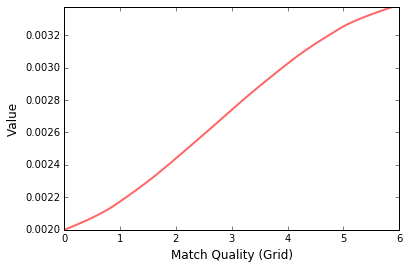

In [14]:
### v_cols: functions that will be integrated with density h_grid or h_0 [varies with each iteration]
q = 56 #change q from 0 to y.size to look at the increasing mean and same variance
r = 30 #change r from 0 to t.size to look at different tenures
fig, ax = plt.subplots()
x = fp.y
z = v_cols[q*(fp.T_max+1)+r][0](x)
ax.set_ylim(np.amin(v_cols[q*(fp.T_max+1)+r][0](x)), np.amax(v_cols[q*(fp.T_max+1)+r][0](x)))
ax.plot(x, z, 'r-', linewidth=2, alpha=0.6)
ax.set_xlabel('Match Quality (Grid)', fontsize=12)
ax.set_ylabel('Value', fontsize=12)
plt.show()

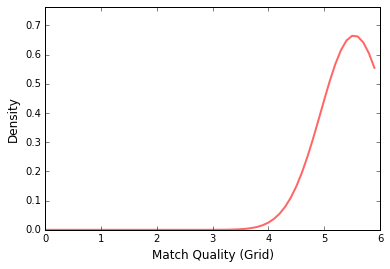

In [15]:
### h_grid: density from beliefs about future quality by grid point when deciding to keep the worker
q = 56 #change q from 0 to y.size to look at the increasing mean and same variance
r = 29 #change r from 0 to t.size to look at different tenures
fig, ax = plt.subplots()
x = fp.y
z = fp.h_grid[q*(fp.T_max+1)+r](x)
ax.set_ylim(np.amin(fp.h_grid[q*(fp.T_max+1)+r](x)), np.amax(fp.h_grid[q*(fp.T_max+1)+r](x))+0.1)
ax.plot(x, z, 'r-', linewidth=2, alpha=0.6)
ax.set_xlabel('Match Quality (Grid)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
plt.show()

In [16]:
#E1
q = 56 #change q from 0 to y.size to look at the increasing mean and same variance
r = 29 #change r from 0 to t.size to look at different tenures
np.array([integrate.fixed_quad(lambda x: v_cols[q*(fp.T_max+1)+r][0](x)*fp.h_grid[q*(fp.T_max+1)+r](x), i-3*j**0.5, i+3*j**0.5)[0]])

array([ 0.00068279])

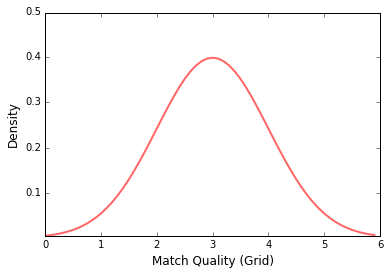

In [17]:
### h_0: density from beliefs about future quality when drawing a new worker
#...this is the prior and does not vary with the grid location
fig, ax = plt.subplots()
x = fp.y
z = fp.h_0(x)
ax.set_ylim(np.amin(fp.h_0(x)), np.amax(fp.h_0(x))+0.1)
ax.plot(x, z, 'r-', linewidth=2, alpha=0.6)
ax.set_xlabel('Match Quality (Grid)', fontsize=12)
ax.set_ylabel('Density', fontsize=12)
plt.show()

In [18]:
#E0
q = 56 #change q from 0 to y.size to look at the increasing mean and same variance
r = 29 #change r from 0 to t.size to look at different tenures
np.array([integrate.fixed_quad(lambda x: v_cols[q*(fp.T_max+1)+r][0](x)*fp.h_0(x), fp.y_0+fp.w/10-3*fp.sig2_0**0.5, fp.y_0+fp.w/10+3*fp.sig2_0**0.5)[0]])

array([ 0.01054689])

In [19]:
(policy[0,:,30], optimal_policy[0,:,30])

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

In [20]:
(v0[0,:,30], v1[0,:,30])

(array([ 0.00195056,  0.00196328,  0.00197637,  0.00198988,  0.00200393,
         0.00201862,  0.00203412,  0.00205063,  0.00206846,  0.00208808,
         0.00210954,  0.00213132,  0.00215348,  0.00217606,  0.00219915,
         0.00222283,  0.00224721,  0.00227231,  0.00229809,  0.00232437,
         0.00235085,  0.00237748,  0.00240419,  0.00243099,  0.00245789,
         0.00248491,  0.00251205,  0.00253932,  0.00256668,  0.0025941 ,
         0.00262155,  0.00264888,  0.00267585,  0.00270241,  0.00272856,
         0.00275432,  0.00277975,  0.00280493,  0.00282992,  0.00285479,
         0.00287952,  0.00290367,  0.00292672,  0.00294884,  0.00297009,
         0.00299067,  0.00301072,  0.00303035,  0.00304967,  0.00306873,
         0.00308715,  0.00310293,  0.0031171 ,  0.00313025,  0.00314266,
         0.00315451,  0.00316594,  0.00317703,  0.00318784,  0.00319844]),
 array([ 0.00993792,  0.00993792,  0.00993792,  0.00993792,  0.00993792,
         0.00993792,  0.00993792,  0.00993792,  0

In [21]:
(v0[0,:,29], v1[0,:,29])

(array([ 0.01001954,  0.01001954,  0.01001954,  0.01001954,  0.01001954,
         0.01001954,  0.01001954,  0.01001954,  0.01001954,  0.01001954,
         0.01001954,  0.01001954,  0.01001954,  0.01001954,  0.01001954,
         0.01001954,  0.01001954,  0.01001954,  0.01001954,  0.01001954,
         0.01001954,  0.01001954,  0.01001954,  0.01001954,  0.01001954,
         0.01001954,  0.01001954,  0.01001954,  0.01001954,  0.01001954,
         0.01001954,  0.01001954,  0.01001954,  0.01001954,  0.01001954,
         0.01001954,  0.01001954,  0.01001954,  0.01001954,  0.01001954,
         0.01001954,  0.01001954,  0.01001954,  0.01001954,  0.01001954,
         0.01001954,  0.01001954,  0.01001954,  0.01001954,  0.01001954,
         0.01001954,  0.01001954,  0.01001954,  0.01001954,  0.01001954,
         0.01001954,  0.01001954,  0.01001954,  0.01001954,  0.01001954]),
 array([-1.99006208, -1.99006208, -1.99006208, -1.99006208, -1.99006208,
        -1.99006208, -1.99006208, -1.99006208, -1

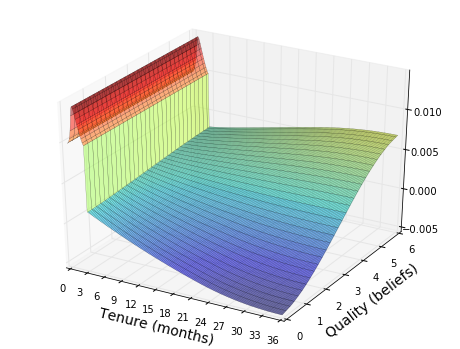

In [22]:
#Keeping Value
v0xxx = v0[:,:,1:] #remove zero
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
tg, yg = np.meshgrid(fp.t, fp.y)
ax.plot_surface(tg,
                yg,
                v0xxx[0,:,:], #for worker 0
                rstride=2, cstride=2,
                cmap=cm.jet,
                alpha=0.5,
                linewidth=0.25)

ax.set_zlim(np.amin(v0xxx[0,:,:]), np.amax(v0xxx[0,:,:]))
ax.set_xlabel('Tenure (months)', fontsize=14)
ax.set_ylabel('Quality (beliefs)', fontsize=14)

ax.set_xlim(0,fp.T_max)
labels = [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36]
plt.xticks(np.linspace(0, fp.T_max+1, (fp.T_max+1)/30+1), labels)
plt.show()

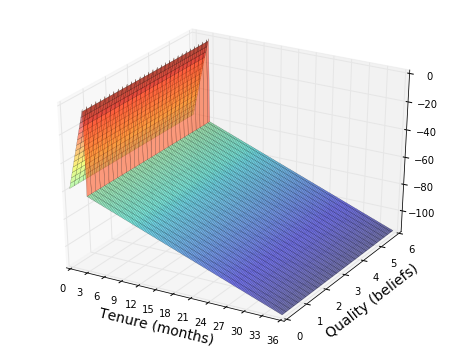

In [23]:
#Firing Value
v1xxx = v1[:,:,1:] #remove zero
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
tg, yg = np.meshgrid(fp.t, fp.y)
ax.plot_surface(tg,
                yg,
                v1xxx[0,:,:], #for worker 0
                rstride=2, cstride=2,
                cmap=cm.jet,
                alpha=0.5,
                linewidth=0.25)

ax.set_zlim(np.amin(v1xxx[0,:,:]), np.amax(v1xxx[0,:,:]))
ax.set_xlabel('Tenure (months)', fontsize=14)
ax.set_ylabel('Quality (beliefs)', fontsize=14)

ax.set_xlim(0,fp.T_max)
labels = [0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36]
plt.xticks(np.linspace(0, fp.T_max+1, (fp.T_max+1)/30+1), labels)
plt.show()